In [87]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft

In [88]:
num_frames = 100
timestep = 0.05
r_vals = np.linspace(0.0, 10.0, 500)
r_vals[0] = 1e-10
M_vals = np.linspace(0, 25.0, len(r_vals))
M_vals[0] = 1e-10
print(f"shape of r_vals : {r_vals.shape}")
print(f"shape of M_vals : {M_vals.shape}")

shape of r_vals : (500,)
shape of M_vals : (500,)


In [89]:
# load the data from G_pred.txt
# the data is of shape (time_frames, r_vals.shape[0])
G_pred = np.loadtxt("G_pred.txt")
print(f"shape of G_pred : {G_pred.shape}")

############### check this step ################
G_pred = G_pred * 2 * np.pi * r_vals
############### check this step ################

# apply the fft to the data on r axis to get K(w, r)
K = fft.fft(G_pred, axis=0)
print(f"shape of K : {K.shape}")
np.savetxt("K.txt", K)

# get omega values
omega_vals = fft.fftfreq(K.shape[0], d=timestep)
print(f"shape of omega_vals : {omega_vals.shape}")

# access real and imaginary parts of K
K_real = np.real(K)
K_imag = np.imag(K)
print(f"shape of K_real : {K_real.shape}")
print(f"shape of K_imag : {K_imag.shape}")



shape of G_pred : (100, 500)
shape of K : (100, 500)
shape of omega_vals : (100,)
shape of K_real : (100, 500)
shape of K_imag : (100, 500)


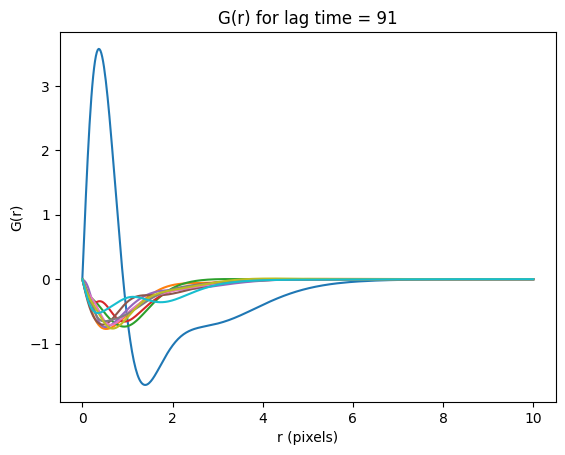

In [90]:
# visualise the real part of S(k, w)
########### IMPLEMENT THIS ##############
# visualise the real part of G_pred_freq
num_freqs = K_real.shape[0]
for i in range(1, num_frames, 10):
    plt.plot(r_vals, K_real[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G(r)")
    plt.title(f"G(r) for lag time = {i}")
plt.show()

In [91]:
num_alphas = 10
num_ds = 50

In [92]:
alpha_vals = np.linspace(0.0, 2.0, num_alphas)
alpha_vals[0] = 1e-10 # set alpha=0 to a small value
d_vals = np.linspace(0.0, 100.0, num_ds)
d_vals[0] = 1e-10 # set d=0 to a small value

# print the shape of the data
print(f"shape of alpha_vals : {alpha_vals.shape}")
print(f"shape of d_vals : {d_vals.shape}")
print(f"shape of omega_vals : {omega_vals.shape}")
# print(omega_vals)

shape of alpha_vals : (10,)
shape of d_vals : (50,)
shape of omega_vals : (100,)


In [93]:
def calc_Z(alpha_vals, d_vals, num_frames, r_vals):
    Z = np.ones((alpha_vals.shape[0], d_vals.shape[0], num_frames, r_vals.shape[0]))
    t_vals = np.linspace(0.0, 5.0, num_frames)
    t_vals[0] = 1e-10 # avoid division by zero
    for i in range(alpha_vals.shape[0]):
        for j in range(d_vals.shape[0]):
            for k in range(r_vals.shape[0]):
                # calculate exp(-r^2/(D*t^alpha)) for each t and perform fft and take real part
                # Z[i, j, k, :] = fft.fft(np.exp(-(r_vals[k]**2)/(d_vals[j]*t_vals**alpha_vals[i]))).real
                Z[i, j, :, k] = fft.fft(np.exp(-(r_vals[k]**2)/(d_vals[j]*(t_vals**alpha_vals[i])))).real

    print("Z.shape = {}".format(Z.shape))     
    return Z

In [94]:
Z = calc_Z(alpha_vals, d_vals, num_frames, r_vals)
# print(Z)

# save Z
# np.save('Z.npy', Z)

Z.shape = (10, 50, 100, 500)


In [95]:
# initialize P_alpha_d
P_alpha_d = np.ones((K_real.shape[0], num_alphas, num_ds))
# P_alpha_d = np.ones((num_alphas, num_ds))
print(f"shape of P_alpha_d : {P_alpha_d.shape}")

P_alpha_d_old = P_alpha_d.copy()
# 

shape of P_alpha_d : (100, 10, 50)


$P_w^{k+1}(\alpha, D) = P_w^k(\alpha, D) \int \frac{K(\omega, r)}{K_{pred}(\omega, r)}Z(\alpha, D, \omega, r) dr$

where

$K_{pred}(\omega, r) = \int \int P_w^k(\alpha, D) Z(\alpha, D, \omega, r)d\alpha dD$

In [96]:
K_pred = np.zeros(K_real.shape)
print(K_pred.shape)

(100, 500)


In [97]:
def integ1(K_pred, P_alpha_d, alpha_vals, d_vals, r_vals, omega_vals):
    # implement the integral in the equation 2
    # $K_{pred}(\omega, r) = \int \int P^k(\alpha, D) Z(\alpha, D, r, \omega)d\alpha dD$

    # the integral is implemented by the trapezoidal rule
    for i in range(K_pred.shape[0]):
        for j in range(K_pred.shape[1]):
            # K_pred[i, j] = np.trapz(np.trapz(P_alpha_d * Z(alpha_vals, d_vals, omega_vals[i], r_vals[j]), d_vals), alpha_vals)
            K_pred[i, j] = np.trapz(np.trapz(P_alpha_d[i] * Z[:, :, i, j], d_vals), alpha_vals)
            # temp = np.trapz(P_alpha_d[i] * Z[:, :, j, i], d_vals)
            # # print(temp.shape)
            # K_pred[i, j] = np.trapz(temp, alpha_vals)

    # normalize K_pred by dividing each element by the sum of its row + 1
    # K_pred = K_pred / (np.sum(K_pred, axis=1)[:, np.newaxis] + 1)
    K_pred = K_pred / (np.sum(K_pred, axis=1) + 1).reshape(-1, 1)

    return K_pred

def integ2(K_pred, P_alpha_d, alpha_vals, d_vals, r_vals, omega_vals):
    # implement the integral in the equation 1
    # $P^{k+1}(\alpha, D) = P^k(\alpha, D) \int \int \frac{K(\omega, r)}{K_{pred}(\omega, r)}Z(\alpha, D, r, \omega) dw dr$

    K_pred[K_pred < 1e-7] = 0.0

    # the integral is implemented by the trapezoidal rule

    # get ratio as K_real / K_pred, but if K_pred is 0, set ratio to 1
    ratio = np.divide(K_real, K_pred, out=np.ones_like(K_real), where=K_pred != 0)
    # print(ratio.shape)


    for i in range(P_alpha_d.shape[0]):
        for j in range(P_alpha_d.shape[1]):
            for k in range(P_alpha_d.shape[2]):

                
                # P_alpha_d[j, k] *= np.trapz(np.trapz(ratio * Z[j, k, :, :], r_vals), omega_vals)

                P_alpha_d[i, j, k] *= np.trapz(ratio[i] * Z[j, k, i, :], r_vals)


    # normalize P_alpha_d by dividing each element by the sum of its 1st and 2nd dimension + 1
    # P_alpha_d = P_alpha_d / (np.sum(P_alpha_d, axis=(1, 2))[:, np.newaxis, np.newaxis] + 1)
    P_alpha_d = P_alpha_d / (np.sum(P_alpha_d, axis=(1, 2)) + 1).reshape(-1, 1, 1)
    # P_alpha_d = P_alpha_d / (np.sum(P_alpha_d) + 1)

    # normalize P_alpha_d by dividing each element by the sum of its row + 1
    # P_alpha_d = P_alpha_d / (np.sum(P_alpha_d, axis=1)[:, np.newaxis] + 1)
    # P_alpha_d = P_alpha_d / (np.sum(P_alpha_d, axis=1) + 1).reshape(-1, 1)

    return P_alpha_d    

In [98]:
# iterate until delta is small enough
delta = 10000
num_iter = 0
# temp = np.ones_like(K_pred)
while delta > 1e-3:
    K_pred = integ1(K_pred, P_alpha_d, alpha_vals, d_vals, r_vals, omega_vals)
    P_alpha_d = integ2(K_pred, P_alpha_d, alpha_vals, d_vals, r_vals, omega_vals)
    delta = np.sum((P_alpha_d - P_alpha_d_old)**2)
    print(f"delta : {delta}")
    P_alpha_d_old = P_alpha_d
    num_iter += 1
print(f"num_iter : {num_iter}")

delta : 49800.24330670357
delta : 21619476948.399914
delta : 22579713058.807713
delta : 23779756616.20784
delta : 24808424863.64295
delta : 40000950519.602936


KeyboardInterrupt: 